3DDiff file using smoother step profiles of Kv
================================================================

### Smoothed $\kappa$ profile

What happens if we smooth out the diffusivity profile from a step (Heaviside function) to a smoothed Heaviside function? (The concentration will look smoother but how does it change the tracer transport?)

Smoothed Heaviside function:

$HS(z) = \begin{cases}
\kappa_{bg} &\mbox{if } z<\frac{L}{2}-\epsilon \\
\kappa_{bg}+ \kappa_{can}(0.5 + \frac{z-\epsilon}{2\epsilon} + \frac{1}{2\pi}\sin{\frac{\pi(z-\epsilon)}{\epsilon}}) & \mbox{if } \frac{L}{2}-\epsilon < z < \frac{L}{2}+\epsilon \\
\kappa_{can} & \mbox{if }  \frac{L}{2}+\epsilon < z
 \end{cases} $

We will compare several values of $\epsilon$.


In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.interpolate as interp
import seaborn as sns
import struct

/home/kramosmu/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
import canyon_tools.readout_tools as rout

### Functions

In [3]:
def smoothHS(nx, xi, epsilon, dx, k1, k2):
    '''Build smooth Heaviside function, of width 2*epsilon centred at index xi
    Check:
    xi < nx ''' 
    
    hs = np.zeros(nx)
    hs[:xi-epsilon+1] = k1
    
    for ii in range(2*epsilon):
        hs[xi+ii-epsilon] = k1+(0.5 + (ii-epsilon)/(2*epsilon) + 
                             (np.sin(np.pi*(ii-epsilon)/epsilon))/(2*np.pi))*k2
    
    hs[xi+epsilon-1:] = k2+k1
    return hs
  
#------------------------------------------------------------------------------------------------------------------------
def smooth_3D_diff(kv_array, W=13000, kbg = 1e-5):
    '''Exponential smoothing of a 3D kv map
    kv_smooth: np array with 3D map of diffusivities
    W: Exponential length scale of decay will be 0.25*W
    kbg: background diffusivity'''
    
    kv_smooth = np.copy(kv_array)
    # Break canyon into 2 sections vertically and horizontally
    xini_h1 = 0
    xfin_h1 = 180
    xini_h2 = 180
    xfin_h2 = 615
    yini_h1 = 0
    yfin_h1 = 75
    yini_h2 = 267
    yfin_h2 = 359

    # Apply exponential smoothing to each half
    for kk in range(90):
        
        for jj in range(360):
            for ii in range(xini_h2, xfin_h2, 1):
                if np.isnan(kv_array[kk,jj,ii+1]) == True:
                    lam = -(1/(0.25*W))*np.log(kbg/kv_array[kk,jj,ii]) 
                    k_sm = kv_array[kk,jj,ii]*np.exp(-lam*(X[ii:]-X[ii]))
                    kv_smooth[kk,jj,ii:] = k_sm
                    break

            for ii in range(xfin_h1, xini_h1, -1):
                if np.isnan(kv_array[kk,jj,ii-1]) == True:
                    lam = -(1/(0.25*W))*np.log(kbg/kv_array[kk,jj,ii]) 
                    k_sm = kv_array[kk,jj,ii]*np.exp(-lam*(-X[:ii]+X[ii]))
                    kv_smooth[kk,jj,:ii] = k_sm
                    break

        for ii in range(616):
            for jj in range(yini_h2, yfin_h2, 1):
                if np.isnan(kv_array[kk,jj+1,ii]) == True:
                    lam = -(1/(0.25*W))*np.log(kbg/kv_array[kk,jj,ii]) 
                    k_sm = kv_array[kk,jj,ii]*np.exp(-lam*(Y[jj:]-Y[jj]))
                    kv_smooth[kk,jj:,ii] = k_sm
                    break

            for jj in range(yfin_h1, yini_h1, -1):
                if np.isnan(kv_array[kk,jj-1,ii]) == True:
                    lam = -(1/(0.25*W))*np.log(kbg/kv_array[kk,jj,ii]) 
                    k_sm = kv_array[kk,jj,ii]*np.exp(-lam*(-Y[:jj]+Y[jj]))
                    kv_smooth[kk,:jj,ii] = k_sm
                    break

    kv_final = np.where(np.isnan(kv_smooth)== True , kbg, kv_smooth)
    kv_final = np.where(kv_final < kbg , kbg, kv_final)
    return kv_final

#------------------------------------------------------------------------------------------------------------------------
def build_3D_diff_rim(hFacC, kv_bg, kv_can, delta, thresh, RC, dz, epsilon):
    
    kv_array = np.ones(np.shape(hFacC))*np.nan # Initial kv array
    ind_canyon = np.argwhere(delta > thresh) # horizontal indices of canyon, (y,x)
    
    ii = 0

    for ind in ind_canyon:
        rim_ind = np.argmin(hFacC[:,ind[0],ind[1]]) # find bottom z-index (first zero in hFacC no canyon)

        if rim_ind == 0: # this means hfac=1 through the whole water col
            rim_ind = 89

        dz_rim = dz[rim_ind]
        
        kappa_profile = smoothHS(nz, rim_ind, int(epsilon/dz_rim), dz_rim, kv_bg, kv_can) 
        
        kv_array[:, ind[0], ind[1]] = kappa_profile
        ii = ii+1

    return kv_array

#------------------------------------------------------------------------------------------------------------------------
def final_3D_diff(hFacCnoc, kv_bg, kv_can, delta, thresh, RC, dz, epsilon, W=13000, kbg = 1e-5):
    '''make final, smoothed 3D map of diffusivities based on kv_profile'''
    
    kv_temp = build_3D_diff_rim(hFacCnoc, kv_bg,kv_can, delta, thresh, RC, dz, epsilon)
    kv_map = smooth_3D_diff(kv_temp, W, kbg)
    
    return kv_map

In [4]:
def plot_sections(kv_map, canyon_name):

    masked_logkvsm = np.ma.masked_array(np.log10(kv_map), mask = land_mask)

    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,10.5))

    mesh = ax1.pcolor(Y[:]/1000,RC[:], masked_logkvsm[:,:,180] , vmax=-1, vmin=-6, cmap = cmo.cm.delta)
    cb = plt.colorbar(mesh, ax=ax1)
    cb.set_label(r'log$_{10}$($K_v$ / m$^2$s$^{-1}$)')
    ax1.set_title('Cross-section along canyon axis, %s' %canyon_name)
    ax1.set_ylabel('m')
    ax1.set_xlabel('km')
    ax1.plot(Y[:]/1000, -depth_Can[:,280], 'k-')

    mesh = ax2.pcolor(X[:]/1000,RC[:], masked_logkvsm[:,227,:], vmax=-1, vmin=-6, cmap = cmo.cm.delta)
    cb = plt.colorbar(mesh, ax=ax2)
    cb.set_label(r'log$_{10}$($K_v$ / m$^2$s$^{-1}$)')
    ax2.set_title('Cross-section along mid-length')
    ax2.set_ylabel('m')
    ax2.set_xlabel('km')
    ax2.set_ylim(-600,0)
    ax2.set_xlim(45,75)

    mesh = ax3.pcolor(X[:]/1000,Y[:]/1000, masked_logkvsm[29,:,:], vmax=-1, vmin=-6, cmap = cmo.cm.delta)
    cb = plt.colorbar(mesh, ax=ax3)
    cb.set_label(r'log$_{10}$($K_v$ / m$^2$s$^{-1}$)')
    ax3.set_title('Top view at depth %1.1f m' % RC[29])
    ax3.set_ylabel('km')
    ax3.set_xlabel('km')
    ax3.set_aspect(1)

    plt.tight_layout()
    
    return(fig, ax1, ax2, ax3)

### Input

In [5]:
## Get grid variables

fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run41/gridGlob.nc'
GridOutNoC = Dataset(fileNoC)

fileCan='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
GridOut = Dataset(fileCan)

depth_NoC = rout.getField(fileNoC,'Depth')
depth_Can = rout.getField(fileCan,'Depth')

hFacC = rout.getField(fileNoC,'HFacC') #(90,616,360)
hFacCcan = rout.getField(fileCan,'HFacC') #(90,616,360)
land_mask = rout.getMask(fileCan, 'HFacC') 

Y = GridOut.variables['Y']
X = GridOut.variables['X']
RC = GridOut.variables['RC']

dz_vec = GridOut.variables['drC'][:]

### Heaviside profiles of diffusivity

These will be the profiles I'll use as smooth steps. I need to interpolate them to the rim depth as I did for the "realistic profiles", stretching and squeezing them as needed along and across the canyon.

In [6]:
#Input 
nx = 616
ny = 360
nz = 90
dz = 5 # m at rim

# Space
L = 1200            # total depth (m)

# Diffusivity
kappa_bg = 1E-5              # background diffusivity
kappa_can = 1E-2 
kappa_exact_step = (1E-2)-(1E-5)# canyon diffusivity
kappa_exact_1E3 = (1E-3)-(1E-5)# canyon diffusivity
kappa_exact_5E3 = (5E-3)-(1E-5)# canyon diffusivity

In [8]:
# Make profiles using different smoothing length scale epsilon. 
# Min epsilon I can use is 5 m = dz but that just looks like a step

e5 = 1 # 5m/dz
kappa_e5 = smoothHS(nz, 26, e5, dz, kappa_bg, kappa_can) 
# index 26 corresponds to the rim at station DnS, but the rim location changes from place to place in the canyon

e10 = 2 # 10m/dz
kappa_e10 = smoothHS(nz, 26, e10, dz, kappa_bg, kappa_can) 

e15 = 3 # 15m/dz
kappa_e15 = smoothHS(nz, 26, e15, dz, kappa_bg, kappa_can) 

e25 = 5 # 25m/dz
kappa_e25 = smoothHS(nz, 26, e25, dz, kappa_bg, kappa_can)

e50 = 10 # 50m/dz
kappa_e50 = smoothHS(nz, 26, e50, dz, kappa_bg, kappa_can)

e75 = 15 # 75m/dz
kappa_e75 = smoothHS(nz, 26, e75, dz, kappa_bg, kappa_can)

e100 = 20 # 100m/dz
kappa_e100 = smoothHS(nz, 26, e100, dz, kappa_bg, kappa_can)

e150 = 30 # 200m/dz
kappa_e150 = smoothHS(nz, 26, e150, dz, kappa_bg, kappa_can)

In [9]:
kappa_e5exact = smoothHS(nz, 26, e5, dz, kappa_bg, kappa_exact_step) 
kappa_e5exact1E3 = smoothHS(nz, 26, e5, dz, kappa_bg, kappa_exact_1E3) 
kappa_e5exact5E3 = smoothHS(nz, 26, e5, dz, kappa_bg, kappa_exact_5E3) 

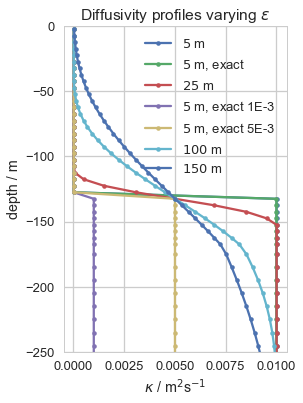

In [14]:
# Plot kv profiles
sns.set_context('talk')
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(4,6))

ax.plot(kappa_e5,RC,'.-', label = '$5$ m')
ax.plot(kappa_e5exact,RC,'.-', label = '$5$ m, exact')
ax.plot(kappa_e25,RC,'.-', label = '$25$ m')
ax.plot(kappa_e5exact1E3,RC,'.-', label = '$5$ m, exact 1E-3')
ax.plot(kappa_e5exact5E3,RC,'.-', label = '$5$ m, exact 5E-3')
ax.plot(kappa_e100,RC,'.-', label = '$100$ m')
ax.plot(kappa_e150,RC,'.-', label = '$150$ m')


ax.set_xlabel('$\kappa$ / m$^2$s$^{-1}$')
ax.set_ylabel('depth / m')
ax.set_title('Diffusivity profiles varying $\epsilon$')

ax.set_ylim(-250,0)
ax.legend(loc=0)

### Find canyon indices

In [15]:
# Isolate canyon
thresh = 5.0 # min vertical resolution
delta = depth_Can-depth_NoC
delta_masked = np.ma.masked_less_equal(delta, thresh)
    
print(np.shape(delta))

(360, 616)


Text(0,0.5,'km')

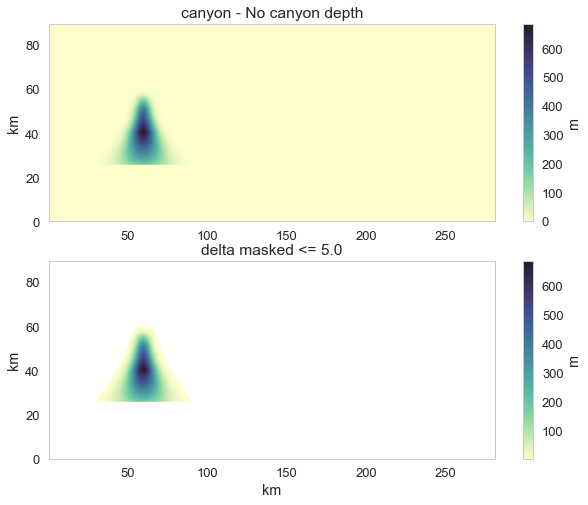

In [16]:
sns.set_context('talk')
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
mesh = ax1.pcolor(X[:]/1000,Y[:]/1000, delta, cmap = cmo.cm.deep)
cb = plt.colorbar(mesh, ax=ax1)
cb.set_label('m')
ax1.set_title('canyon - No canyon depth')
ax1.set_ylabel('km')

mesh = ax2.pcolor(X[:]/1000,Y[:]/1000, delta_masked, cmap = cmo.cm.deep)
cb = plt.colorbar(mesh, ax=ax2)
cb.set_label('m')
ax2.set_title('delta masked <= %1.1f' %thresh)
ax2.set_xlabel('km')
ax2.set_ylabel('km')

### Make 3D maps of kv based on heaviside profiles

Decay lengthscale to K_{bg} is  3250.0 m


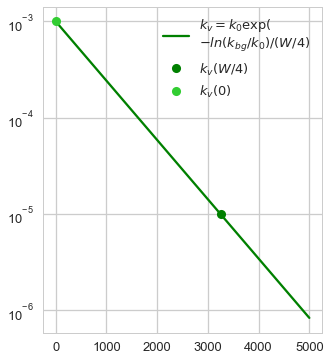

In [17]:
# Find an exponential to smooth out sharp interface 
ko = 1E-3
kbg = 1E-5
W = 13000 # m
lam = -(1/(0.25*W))*np.log(kbg/ko) # decay scale so that at 1/4 of the canyon width the diffusivity is kbg
print('Decay lengthscale to K_{bg} is % 1.1f m' %(0.25*W))

# def exponential
x_vec = np.linspace(0,5000,50)
ksm = ko*np.exp(-lam*x_vec)

# plot
fig, (ax1) = plt.subplots(1,1, figsize=(5,6))
ax1.semilogy(x_vec,ksm, 'g-',label='$k_v=k_0 \exp({$\n$-ln(k_{bg}/k_{0})/(W/4)})$')
ax1.plot(0.25*W, kbg, 'go',label='$k_v(W/4)$' )
ax1.plot(0, ko, 'o',color='limegreen', label='$k_v(0)$')
ax1.legend(loc=0)
plt.show()

In [14]:
# This cell is very sloooooow (the exponential smoothing function is super slow)
kv_final_e10 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 10, W=13000, kbg = 1e-5)
print('done with epsilon 10')

kv_final_e25 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 25, W=13000, kbg = 1e-5)
print('done with epsilon 25')

kv_final_e50 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 50, W=13000, kbg = 1e-5)
print('done with epsilon 50')

kv_final_e100 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 100, W=13000, kbg = 1e-5)
print('done with epsilon 100')

done with epsilon 10
done with epsilon 25
done with epsilon 50
done with epsilon 100


In [15]:
# This cell is very sloooooow (the exponential smoothing function is super slow)
kv_final_e05 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 5, W=13000, kbg = 1e-5)
print('done with epsilon 05')

kv_final_e15 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 15, W=13000, kbg = 1e-5)
print('done with epsilon 15')

kv_final_e75 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 75, W=13000, kbg = 1e-5)
print('done with epsilon 75')

kv_final_e150 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 150, W=13000, kbg = 1e-5)
print('done with epsilon 150')


done with epsilon 05
done with epsilon 15
done with epsilon 75
done with epsilon 150


In [15]:
kv_final_e5exact = final_3D_diff(hFacC, kappa_bg, kappa_exact_step, delta, thresh, RC, 
                                 dz_vec, 5, W=13000, kbg = 1e-5)
print('done with epsilon 5, exact step')


done with epsilon 5, exact step


In [18]:
kv_final_e5exact1E3 = final_3D_diff(hFacC, kappa_bg, kappa_exact_1E3, delta, thresh, RC, 
                                    dz_vec, 5, W=13000, kbg = 1e-5)
print('done with epsilon 5, exact step 1E-3')
kv_final_e5exact5E3 = final_3D_diff(hFacC, kappa_bg, kappa_exact_5E3, delta, thresh, RC, 
                                    dz_vec, 5, W=13000, kbg = 1e-5)
print('done with epsilon 5, exact step 5E03')


done with epsilon 5, exact step 1E-3
done with epsilon 5, exact step 5E03


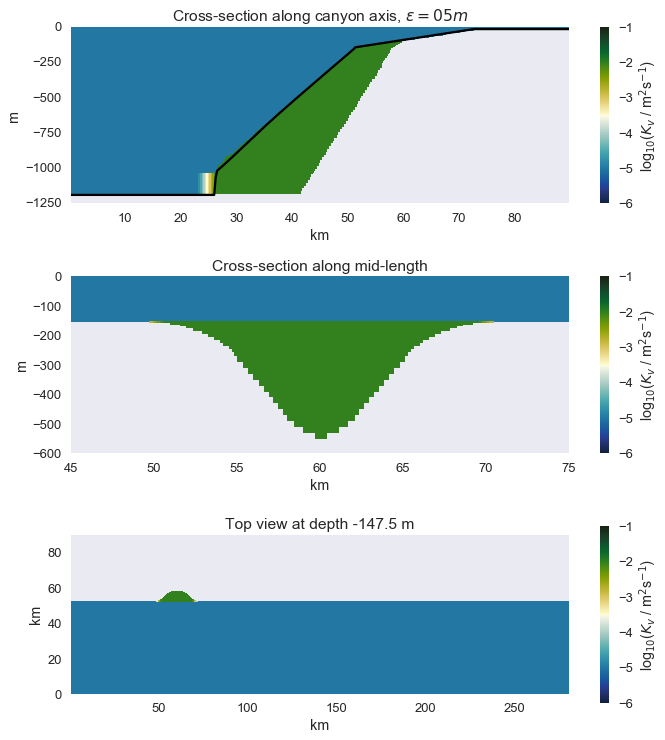

In [16]:
sns.set_style('dark')
fig, ax1, ax2, ax3 = plot_sections(kv_final_e5exact, '$\epsilon=05 m$')

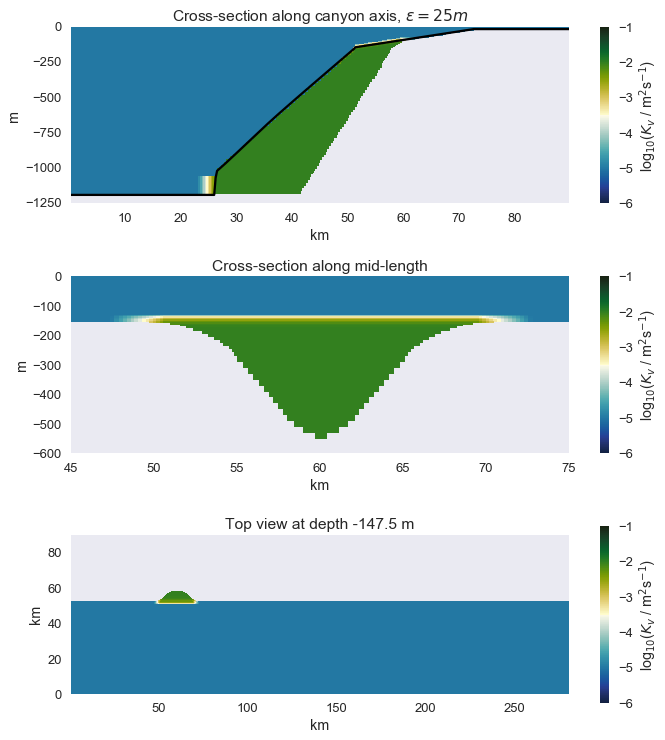

In [16]:
sns.set_style('dark')
fig, ax1, ax2, ax3 = plot_sections(kv_final_e25, '$\epsilon=25 m$')

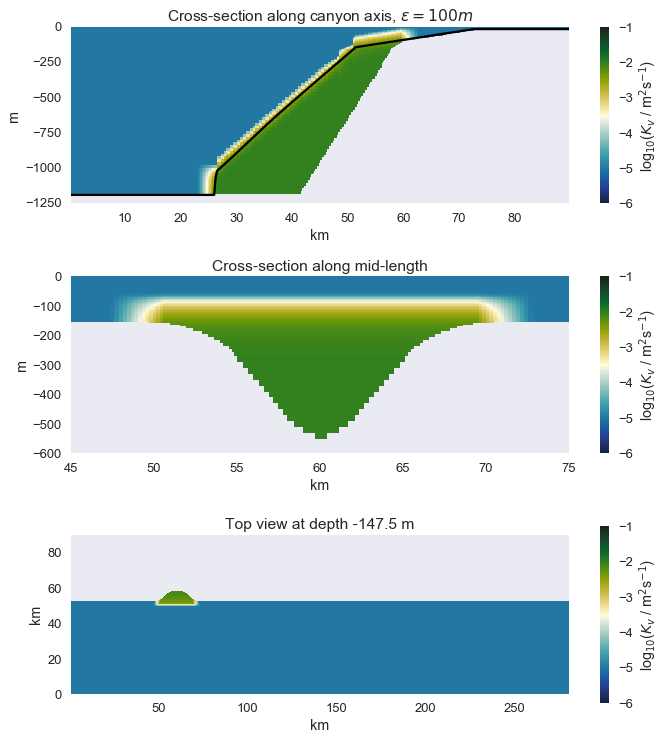

In [17]:
sns.set_style('dark')
fig, ax1, ax2, ax3 = plot_sections(kv_final_e100, '$\epsilon=100 m$')

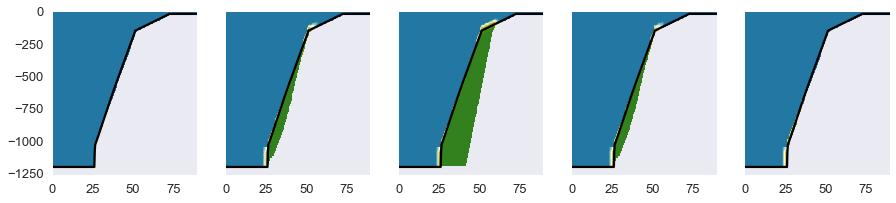

In [18]:
# Make sure it is all good (i.e. plot a lot of cross sections)
masked_array = np.ma.masked_array(np.log10(kv_final_e50), mask = land_mask)

fig, ax = plt.subplots(1,5, figsize=(15,3), sharey = True)
mesh = ax[0].pcolor(Y[:]/1000,RC[:], masked_array[:,:,20],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[1].pcolor(Y[:]/1000,RC[:], masked_array[:,:,120],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[2].pcolor(Y[:]/1000,RC[:], masked_array[:,:,180],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[3].pcolor(Y[:]/1000,RC[:], masked_array[:,:,240],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[4].pcolor(Y[:]/1000,RC[:], masked_array[:,:,285],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)

for ii in range(5):
    ax[ii].plot(Y[:]/1000, -depth_Can[:,280], 'k-')


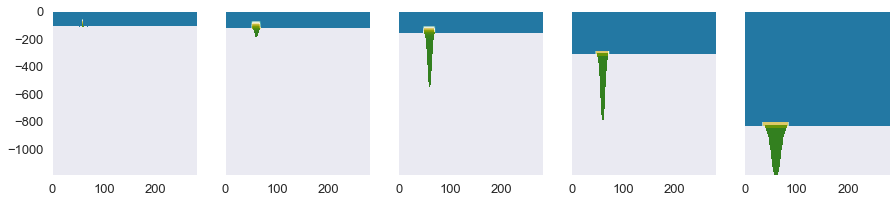

In [19]:
# Make sure it is all good (i.e. plot a lot of cross sections)
masked_array = np.ma.masked_array(np.log10(kv_final_e50), mask = land_mask)

fig, ax = plt.subplots(1,5, figsize=(15,3), sharey = True)
mesh = ax[0].pcolor(X[:]/1000,RC[:], masked_array[:,267,:],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[1].pcolor(X[:]/1000,RC[:], masked_array[:,257,:],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[2].pcolor(X[:]/1000,RC[:], masked_array[:,227,:],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[3].pcolor(X[:]/1000,RC[:], masked_array[:,200,:],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[4].pcolor(X[:]/1000,RC[:], masked_array[:,100,:],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)


In [20]:
# save binary files

filename = "%dx%dx%d/KrDiff_e10_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename2 = "%dx%dx%d/KrDiff_e25_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename3 = "%dx%dx%d/KrDiff_e50_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename4 = "%dx%dx%d/KrDiff_e100_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename5 = "%dx%dx%d/KrDiff_e15_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename6 = "%dx%dx%d/KrDiff_e75_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename7 = "%dx%dx%d/KrDiff_e150_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename8 = "%dx%dx%d/KrDiff_e05_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)


dt = np.dtype('>f8')  # float 64 big endian
fileobj = open(filename,mode='wb')
kv_final_e10.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename2,mode='wb')
kv_final_e25.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename3,mode='wb')
kv_final_e50.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename4,mode='wb')
kv_final_e100.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename5,mode='wb')
kv_final_e15.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename6,mode='wb')
kv_final_e75.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename7,mode='wb')
kv_final_e150.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename8,mode='wb')
kv_final_e05.astype(dt).tofile(fileobj,"")
fileobj.close()

In [18]:
dt = np.dtype('>f8')  # float 64 big endian
filename9 = "%dx%dx%d/KrDiff_e05_exact_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(filename9,mode='wb')
kv_final_e5exact.astype(dt).tofile(fileobj,"")
fileobj.close()

In [19]:
dt = np.dtype('>f8')  # float 64 big endian
filename10 = "%dx%dx%d/KrDiff_e05_exact1E3_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(filename10,mode='wb')
kv_final_e5exact1E3.astype(dt).tofile(fileobj,"")
fileobj.close()

filename11 = "%dx%dx%d/KrDiff_e05_exact5E3_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(filename11,mode='wb')
kv_final_e5exact5E3.astype(dt).tofile(fileobj,"")
fileobj.close()

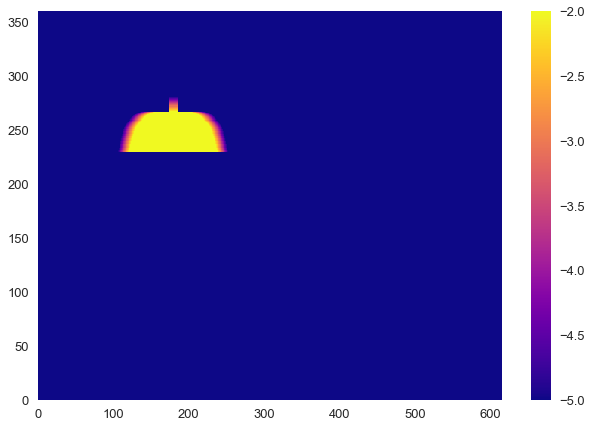

In [21]:
# Check that the values of the file are in the right order 

dt = np.dtype('>f8')  # float 64 big endian

fileNAME = filename8
kv=np.fromfile(fileNAME, dt)

Kv=np.reshape(kv,(nz,ny,nx),order='C')
np.shape(Kv)

plt.pcolor(np.log10(Kv[29,:,:]), cmap='plasma')
plt.colorbar()
